# IBM Applied Data Science - Capstone Project
*Notebook used for submission of peer-graded assignment*

*First full ML project in python*

## Prediction of Car Accident Severity in Seattle, USA

# 1. Introduction / Business Problem
The purpose of this exploratory data analysis exercise is to assess the possibility and accuracy to predict car accident severity in Seattle, USA by means of supervised machine learning models, exploiting collision track records from past accidents that were recorded by the Seattle Police Department (SPD) and provided as open data by Traffic Records.

Being able to predict car accident severity from extrenal factors like weather, location, road conditions as well as speeding, influence of alcohol/drugs etc. will allow the government to put appropriate meassures in place to reduce accident severity, but above all, allow the police and first response teams to channel their ressources and increase efficiency.

# 2. Data Overview

The data used in this project is was recorded by the Seattle Police Department (SPD) and provided as open data by Traffic Records. The spradsheet can be downloaded free of charge from the [Seattle GeoData Portal](https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0?geometry=-122.326%2C47.592%2C-122.318%2C47.594) and have been acquired since 2004.

The dataset used in this study comprises **194673** accidents, recorded and documented in Seattle in March 2013.
Apart from the target variable, the severity of the collision `SEVERITYCODE`, meta information from 37 additional features are available. These comprise information about location of the accident (e.g. `X`,`Y`,`LOCATION`, `JUNCTIONTYPE`, `CROSSWALKKEY`, `SEGLANEKEY`,`HITPARKEDCAR`, `ADDRTYPE`), external factors (e.g. `LIGHTCOND`, `WEATHER`, `ROADCOND`) or lawlessness (e.g. `INATTENTIONIND`,`UNDERINFL`, `PEDROWNOTGRN`, `SPEEDING`).

The severity of the collision is categorised as
* **1: Accidents resulting in property damage**
* **2: Accidents resulting in injuries**

For additional information about the individual attributes kindly refer to the official corresponding documentation that can be found [here](https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf).

A first overview of the spatial distribution of car accidents in 2013 can be found below. Note the increased number of accident at intersections (zoom in).

### Methodology

The data analysis workflow is designed as follows:

**1\.  Data Loading**: 
* Downloading the data from the online repository and storing into Pandas dataframe.

**2\. Data Overview**:
* Exploring the data dimensionality, format, quality, and volume.

**3\. Data Clean-up**:
* Re-formatting and encoding the data to make fit-for-purpose.

**4\. Exploratory Data Analysis**:
* Getting insight into distribution, frequency, anc correlation of features. 
* Pre-selection of input features for model training.

**5\. Model Building**:
* Normalizing the data
* Benchmarking different models against each other (K-Nearest Neighbor, Decision Tree, Logistic Regression)

(**6\. Model Deployment and Evaluation**)

***

<a id='load_data'></a>
## 2.2 Data Loading

In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium import plugins

# Load the data and save data to pandas data frame
data_url = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(data_url)

# Plot heatmap
loc = 'Density Map of Traffic Accidents, Seattle (March 2013)'
title_html = '''
             <h3 align="center" style="font-size:15px"><b>{}</b></h3>
             '''.format(loc)  

locations = df[['Y', 'X']][df['Y'].notna()]
heatmap = folium.Map(location=[47.605, -122.3], zoom_start=11, tiles='CartoDB dark_matter')

heatmap.add_child(folium.plugins.HeatMap(locations[['Y', 'X']].values, radius=8, cmap='viridis'))
heatmap.get_root().html.add_child(folium.Element(title_html))
heatmap

### 2.3 Data Overview

In [6]:
# all raw data stored in dataframe df

print(f"Dimensions: {df.shape}")
df.info()

Dimensions: (194673, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null

The input data contains 194673 entries and is split into 38 features of which `SEVERITYCODE` will be the target value to predict.
***

In [8]:
# Distribution of the target value SEVERITYCODE

feature="SEVERITYCODE"
df[feature].value_counts().to_frame()

SEVERITYCODE
1        136485
2         58188

In [14]:
def df_qc(df):

    missing_data = df.isnull()
    df_nan = pd.DataFrame(columns=['ID', 'val', 'nan'])

    for column in missing_data.columns.values.tolist():
        try:
            val_ok = missing_data[column].value_counts()[0]
            val_nan = missing_data[column].value_counts()[1]

            df_new_row = pd.DataFrame(data=np.array([[column,val_ok,val_nan]]), columns=['ID','val','nan'])
            df_nan = pd.concat([df_nan,df_new_row], ignore_index=True)

        except:
            val_ok = missing_data[column].value_counts()[0]
            df_new_row = pd.DataFrame(data=np.array([[column,val_ok,0]]), columns=['ID','val','nan'])
            df_nan = pd.concat([df_nan,df_new_row], ignore_index=True)

    # cast values as integer
    df_nan = df_nan.astype({'val' :'int','nan':'int'})

    df_nan.set_index('ID', inplace=True)
    df_nan.sort_values(['nan'], ascending=True, axis=0, inplace=True)

    return df_nan

# Function to plot histograms from features
def plt_hist_col(data_frame,column_name):
    '''
    Function to plot distribution of unique value counts of a SINGLE COLUMN in a data frame.
    
    INPUT:
    data_frame: Pandas data frame
    column_name: exact column name (STR)
    '''
    
    tot_len = len(data_frame[column_name])
    data_frame_perc = round((pd.Series(data_frame[column_name]).value_counts() / tot_len * 100),3)
    td = data_frame_perc.to_frame()

    ax1 = td.plot(kind="bar", figsize=(14,3), rot=90, width = 0.4)
    ax1.set_yticks(np.arange(0, 110, 10))
    ax1.set_title('Relative distribution of value counts for '+ str(column_name)+'  ('+str(tot_len)+' total)', fontsize=12)
    
    for p in ax1.patches:
        ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() + 2), fontsize=10, color="r")
    plt.show()
    
    return(ax1)


In [10]:
# NaN values per feature
df_qc(df)

val     nan
ID                            
SEVERITYCODE    194673       0
SEGLANEKEY      194673       0
SDOT_COLDESC    194673       0
SDOT_COLCODE    194673       0
INCDTTM         194673       0
INCDATE         194673       0
VEHCOUNT        194673       0
CROSSWALKKEY    194673       0
PEDCOUNT        194673       0
PERSONCOUNT     194673       0
SEVERITYDESC    194673       0
SEVERITYCODE.1  194673       0
PEDCYLCOUNT     194673       0
HITPARKEDCAR    194673       0
OBJECTID        194673       0
COLDETKEY       194673       0
REPORTNO        194673       0
STATUS          194673       0
INCKEY          194673       0
ST_COLCODE      194655      18
ADDRTYPE        192747    1926
LOCATION        191996    2677
UNDERINFL       189789    4884
COLLISIONTYPE   189769    4904
ST_COLDESC      189769    4904
ROADCOND        189661    5012
WEATHER         189592    5081
LIGHTCOND       189503    5170
X               189339    5334
Y               189339    5334
JUNCTIONTYPE    188344    6329
SDOTCOLNUM      114936   79737
EXCEPTRSNCODE    84811  109862
INTKEY           65070  129603
INATTENTIONIND   29805  164868
SPEEDING          9333  185340
EXCEPTRSNDESC     5638  189035
PEDROWNOTGRNT     4667  190006

### 2.4 Data Clean-up

In [12]:
# Extract Year and Month and create new column
df_c = df.copy()
df_c["YEAR"] = int(df["INCDATE"][0][0:4])
df_c["MONTH"] = int(df["INCDATE"][0][5:7])
df_c.drop(['INCDATE'], axis=1, inplace=True)

# list with the flagged features that will be deleted
del_list = ["COLDETKEY", "REPORTNO", "STATUS", "INTKEY", "EXCEPTRSNCODE", "EXCEPTRSNDESC",
           "SEVERITYCODE.1","SEVERITYDESC","INCDTTM","PEDROWNOTGRNT","SDOTCOLNUM",
            "ST_COLCODE","ST_COLDESC","YEAR","MONTH"]

# delete columns based on del_list entries
df_c_qc = df_c.copy()
df_c_qc.drop(del_list, axis=1, inplace=True)

# reformat and encode individual column entries into integers for 
# simple math. Hot-encoding is done in a subsequent step
feature="ADDRTYPE"
df_c_qc = df_c_qc[df_c_qc[feature].notna()]

feature="INATTENTIONIND"
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "0")
df_c_qc[feature] = df_c_qc[feature].replace("Y", "1")
df_c_qc[feature] = df_c_qc[feature].astype("int64", errors='ignore')

feature="HITPARKEDCAR"
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "0")
df_c_qc[feature] = df_c_qc[feature].replace("Y", "1")
df_c_qc[feature] = df_c_qc[feature].replace("N", "0")
df_c_qc[feature] = df_c_qc[feature].astype("int64")

feature="UNDERINFL"
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "0")
df_c_qc[feature] = df_c_qc[feature].replace("N", "0")
df_c_qc[feature] = df_c_qc[feature].replace("Y", "1")
df_c_qc[feature] = df_c_qc[feature].astype("int64", errors='ignore')

feature="SPEEDING"
df_c_qc[feature] = df_c_qc[feature].replace("Y", "1")
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "0")
df_c_qc[feature] = df_c_qc[feature].astype("int64", errors='ignore')

feature="WEATHER"
df_c_qc[feature] = df_c_qc[feature].replace("Other", "Unknown")
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "Unknown")
df_c_qc[(feature)+'_INT'] = df_c_qc[feature].replace({'Clear': '1', 
                                                      'Partly Cloudy': '2', 
                                                      'Overcast': '3', 
                                                      'Severe Crosswind': '4', 
                                                      'Raining':'6',
                                                      'Blowing Sand/Dirt':'7',
                                                      'Sleet/Hail/Freezing Rain': '8',
                                                      'Fog/Smog/Smoke':'9',
                                                      'Snowing':'10',
                                                      'Unknown':'5',               
                                                     })
df_c_qc[(feature)+'_INT'] = df_c_qc[(feature)+'_INT'].astype("int64", errors='ignore')

feature="ROADCOND"
df_c_qc[feature] = df_c_qc[feature].replace("Other", "Unknown")
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "Unknown")
df_c_qc[(feature)+'_INT'] = df_c_qc[feature].replace({'Dry': '1', 
                                                      'Sand/Mud/Dirt': '2', 
                                                      'Wet': '3', 
                                                      'Unknown': '4', 
                                                      'Standing Water':'5',
                                                      'Snow/Slush':'6',
                                                      'Ice': '7',
                                                      'Oil':'8',              
                                                     })
df_c_qc[(feature)+'_INT'] = df_c_qc[(feature)+'_INT'].astype("int64", errors='ignore')

feature="LIGHTCOND"
df_c_qc[feature] = df_c_qc[feature].replace("Other", "Unknown")
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "Unknown")
df_c_qc[feature] = df_c_qc[feature].replace("Dark - No Street Lights", "Dark - Street Lights Off")
df_c_qc[(feature)+'_INT'] = df_c_qc[feature].replace({'Daylight': '1', 
                                                      'Dusk': '2', 
                                                      'Dawn': '3', 
                                                      'Dark - Street Lights On': '4',
                                                      'Unknown': '5' ,
                                                      'Dark - Unknown Lighting':'6',
                                                      'Dark - Street Lights Off':'7',        
                                                     })
df_c_qc[(feature)+'_INT'] = df_c_qc[(feature)+'_INT'].astype("int64")



feature="LOCATION"
df_c_qc[(feature)+'_INT'] = pd.factorize(df_c_qc[feature])[0] + 1

feature="JUNCTIONTYPE"
df_c_qc[feature] = df_c_qc[feature].replace(np.nan, "Unknown")
df_c_qc[(feature)+'_INT'] = df_c_qc[feature].replace({'Mid-Block (not related to intersection)': '1', 
                                                      'At Intersection (intersection related)': '2', 
                                                      'Mid-Block (but intersection related)': '3', 
                                                      'Unknown': '4',
                                                      'At Intersection (but not related to intersection)': '5' ,
                                                      'Ramp Junction':'6',
                                                      'Driveway Junction':'7',        
                                                     })
df_c_qc[(feature)+'_INT'] = df_c_qc[(feature)+'_INT'].astype("int64")

feature="ADDRTYPE"
#df_c_qc[(feature)+'_INT'] = pd.factorize(df_c_qc[feature])[0] + 1
df_c_qc[(feature)+'_INT'] = df_c_qc[feature].replace({'Block': '1', 
                                                      'Alley': '2', 
                                                      'Intersection': '3',       
                                                     })
df_c_qc[(feature)+'_INT'] = df_c_qc[(feature)+'_INT'].astype("int64")

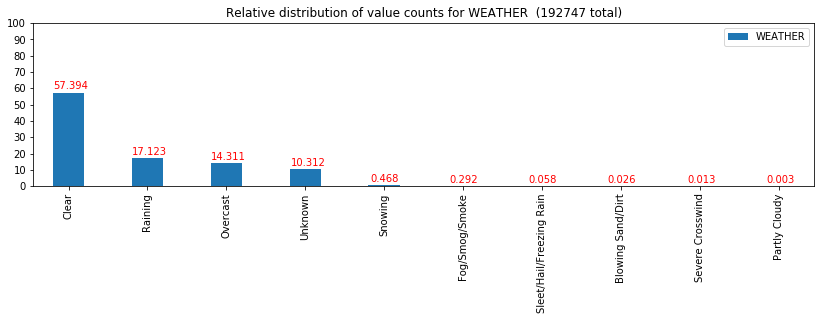

In [15]:
plt_hist_col(df_c_qc,'WEATHER')

### 2.5 Exploratory Data Analysis

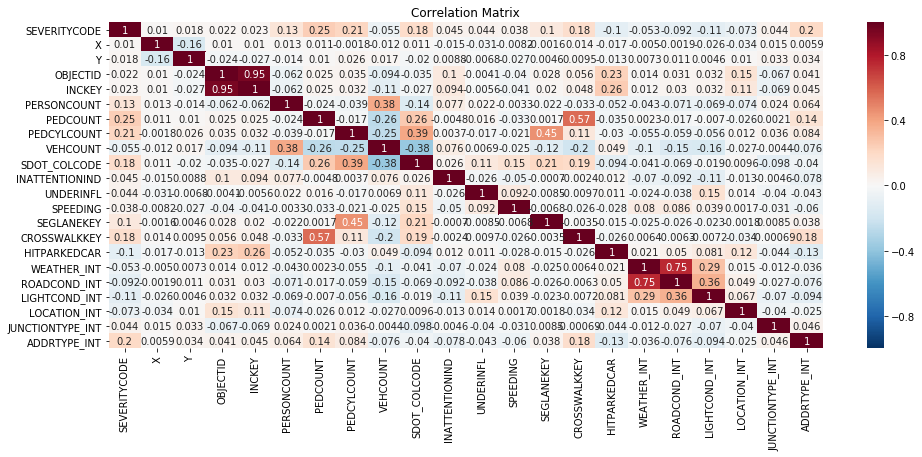

In [16]:
# Correlation matrix of cleaned-up dataframe
corr = df_c_qc.corr()

plt.figure(figsize = (16,6))
corr_plot = sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,cmap='RdBu_r', vmin=-1, vmax=1, annot=True)
corr_plot.set_title('Correlation Matrix', fontsize=12)
corr_plot

A first look into the correlation matrix of the features from the cleaned-up dataframe reveals:

* As expected `X`/ `Y` have a low correlation value with the other data and can therefore be discarded
* Positive correlation between the involvement of pedestrians (`PEDCOUNT` /`CROSSWALKKEY` / `SEGLANEKEY`) or cyclists (`PEDCLCOUNT`) and severity `SEVERITYCODE`.
* A high positive correlation between `WEATHER_INT` and `ROADCOND_INT`
* A mild correlation between `UNDERINFL` and `LIGHTCOND_INT` suggesting drunk driving occurs more often at night.
    
Moreover, features like `OBJECTID`, `COLLISIONTYPE`, `SDOT_COLCODE` and `SDOT_COLCODESC` are assigned by the police after the accident and will therefore be dropped.

In [17]:
# clean-up final dataframe
df_c_fin = df_c_qc.drop(['X','Y','OBJECTID',
                         'SDOT_COLCODE', 'SDOT_COLDESC', 'ADDRTYPE', 'LOCATION', 
                         'COLLISIONTYPE'], axis=1)

feature="SEVERITYCODE"
s2_values = round(df_c_fin[feature].value_counts()[2] / (df_c_fin[feature].value_counts()[1]+df_c_fin[feature].value_counts()[2])*100,2)
print(f"Relative amount of type 2 (injuries) accidents of total dataset: {s2_values}%.")

Relative amount of type 2 (injuries) accidents of total dataset: 30.09%.


Analysis of the relative distribution of accidents, leading to property damage only (`SEVERITYCODE=1`) and accidents resulting in injuries (`SEVERITYCODE=2`), shows that with 30%, the latter is underrepresented in the unbalanced input dataset. Consequently all resulting models will be biased towards the former outcome of a collision.
An attempt to overcome this issue is made through **Synthetic Minority Oversampling** [below](#smote).

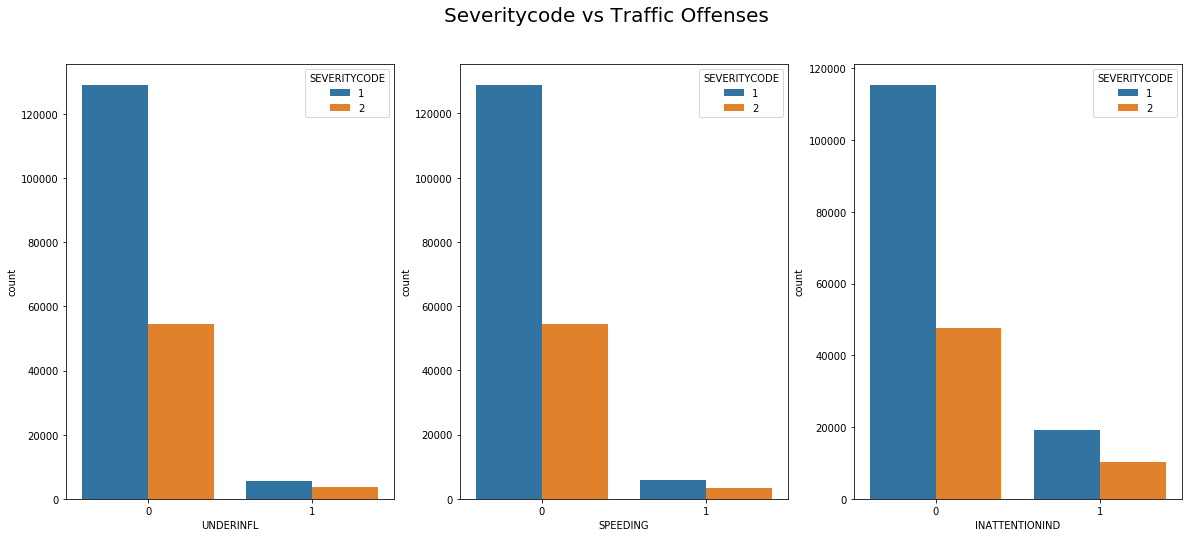

In [18]:
# Impact of features on severitycode #1: traffic offenses

target = "SEVERITYCODE"
features_law = ["UNDERINFL", "SPEEDING", "INATTENTIONIND"]

fig = plt.figure(figsize=(20, 8)) # create figure
fig.suptitle("Severitycode vs Traffic Offenses", fontsize='20')
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#df_c_fin.plot(kind='bar', ax=ax1)
sns.catplot(x=features_law[0], kind='count', hue=target, data=df_c_fin, ax=ax1)
sns.catplot(x=features_law[1], kind='count', hue=target, data=df_c_fin, ax=ax2)
sns.catplot(x=features_law[2], kind='count', hue=target, data=df_c_fin, ax=ax3)
ax1.legend(loc='upper right',title=target)
ax2.legend(loc='upper right',title=target)
ax3.legend(loc='upper right',title=target)

plt.close(2) 
plt.close(3)
plt.close(4)

In [19]:
for i,f in enumerate(features_law):
    
    sev1Y = df_c_fin[(df_c_fin["SEVERITYCODE"] == 1) & (df_c_fin[f] == 1)].shape[0]
    sev1N = df_c_fin[(df_c_fin["SEVERITYCODE"] == 1) & (df_c_fin[f] == 0)].shape[0]
    
    sev2Y = df_c_fin[(df_c_fin["SEVERITYCODE"] == 2) & (df_c_fin[f] == 1)].shape[0]
    sev2N = df_c_fin[(df_c_fin["SEVERITYCODE"] == 2) & (df_c_fin[f] == 0)].shape[0]
    
    print(f"{f}:\n  {round(sev2Y / (sev1Y+sev2Y) * 100,2)}% of accidents with {f}=1 have {target}=2.")
    print(f"  {round(sev2N / (sev1N+sev2N) * 100,2)}% of accidents with {f}=0 have {target}=2.")

UNDERINFL:
  39.06% of accidents with UNDERINFL=1 have SEVERITYCODE=2.
  29.65% of accidents with UNDERINFL=0 have SEVERITYCODE=2.
SPEEDING:
  37.87% of accidents with SPEEDING=1 have SEVERITYCODE=2.
  29.7% of accidents with SPEEDING=0 have SEVERITYCODE=2.
INATTENTIONIND:
  34.97% of accidents with INATTENTIONIND=1 have SEVERITYCODE=2.
  29.2% of accidents with INATTENTIONIND=0 have SEVERITYCODE=2.


Analysis of `UNDERINFL`, `SPEEDING`, and  `INATTENTIONIND` vs `SEVERITYCODE` reveals that traffic offenses increase the risks for accidents resulting in injuries (`SEVERITYCODE 2`) by up to 10%.

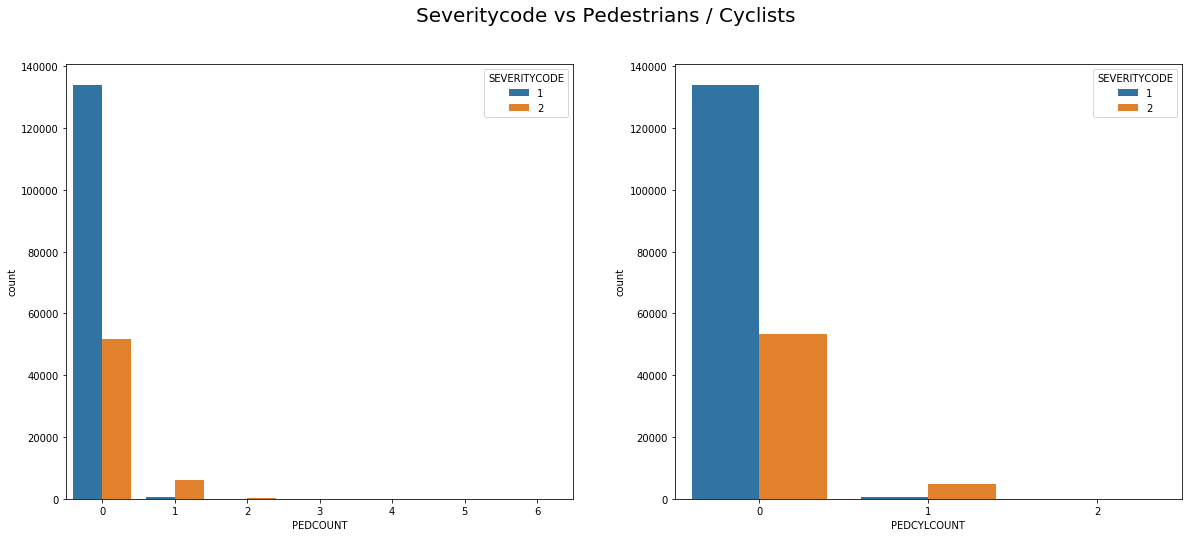

In [21]:
# Impact of features on severitycode #2: pedestrians / cyclists

target = "SEVERITYCODE"
features_ped = ["PEDCOUNT", "PEDCYLCOUNT"]

fig = plt.figure(figsize=(20, 8)) # create figure
fig.suptitle("Severitycode vs Pedestrians / Cyclists", fontsize='20')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.catplot(x=features_ped[0], kind='count', hue=target, data=df_c_fin, ax=ax1)
sns.catplot(x=features_ped[1], kind='count', hue=target, data=df_c_fin, ax=ax2)
ax1.legend(loc='upper right',title=target)
ax2.legend(loc='upper right',title=target)

plt.close(2) 
plt.close(3)

In [22]:
for i,f in enumerate(features_ped):
    
    sev1N = df_c_fin[(df_c_fin["SEVERITYCODE"] == 1) & (df_c_fin[f] == 0)].shape[0]
    sev1Y = df_c_fin[(df_c_fin["SEVERITYCODE"] == 1) & (df_c_fin[f] == 1)].shape[0]
    
    sev2N = df_c_fin[(df_c_fin["SEVERITYCODE"] == 2) & (df_c_fin[f] == 0)].shape[0]
    sev2Y = df_c_fin[(df_c_fin["SEVERITYCODE"] == 2) & (df_c_fin[f] == 1)].shape[0]
    
    print(f"{f}:\n  {round(sev2Y / (sev1Y+sev2Y) * 100,2)}% of accidents with {f}>=1 have {target}=2.")
    print(f"  {round(sev2N / (sev1N+sev2N) * 100,2)}% of accidents with {f}=0 have {target}=2.")

PEDCOUNT:
  89.85% of accidents with PEDCOUNT>=1 have SEVERITYCODE=2.
  27.86% of accidents with PEDCOUNT=0 have SEVERITYCODE=2.
PEDCYLCOUNT:
  87.53% of accidents with PEDCYLCOUNT>=1 have SEVERITYCODE=2.
  28.41% of accidents with PEDCYLCOUNT=0 have SEVERITYCODE=2.


Analysis of `PEDCOUNT` and `PEDCYLCOUNT` vs `SEVERITYCODE` reveals that accidents involving pedestrians or cyclists accidents increase the risk of injuries(`SEVERITYCODE 2`) by up to 70%.

<Figure size 1440x576 with 0 Axes>

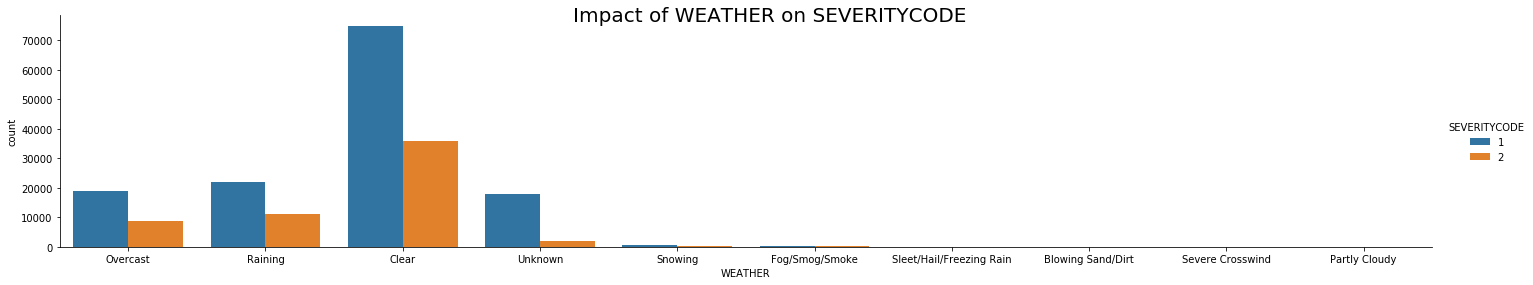

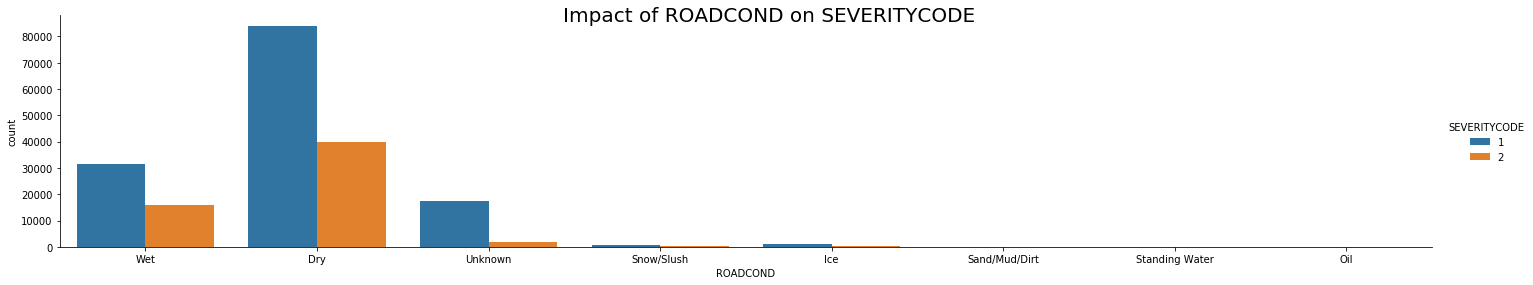

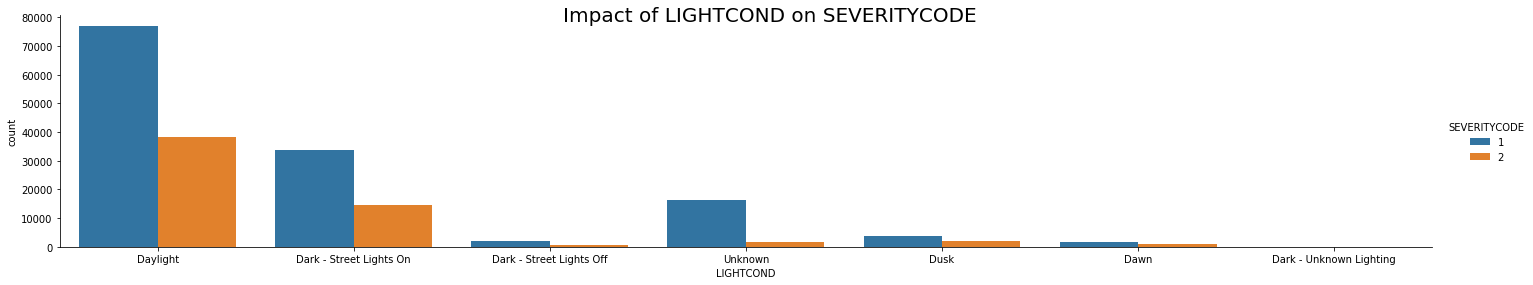

In [23]:
# Impact of features on severitycode #3: weather, daytime, road condition

target = "SEVERITYCODE"
features_ext = ["WEATHER", "ROADCOND", "LIGHTCOND"]

fig = plt.figure(figsize=(20, 8))

ax1 = sns.catplot(x=features_ext[0], kind='count', hue=target, data=df_c_fin, height=4, aspect=5)
ax1.fig.suptitle(('Impact of '+features_ext[0]+' on '+target),size=20)

ax2 = sns.catplot(x=features_ext[1], kind='count', hue=target, data=df_c_fin, height=4, aspect=5)
ax2.fig.suptitle(('Impact of '+features_ext[1]+' on '+target),size=20)

ax3 = sns.catplot(x=features_ext[2], kind='count', hue=target, data=df_c_fin, height=4, aspect=5)
ax3.fig.suptitle(('Impact of '+features_ext[2]+' on '+target),size=20)

plt.show()


In [24]:
# Playing around with dictionary for practice here
#initialise dictionary to count distibution of feature values per SEVERITYCODE
sev_dict = {1:[0,0],2:[0,0],3:[0,0],4:[0,0],5:[0,0],6:[0,0],7:[0,0],8:[0,0],9:[0,0],10:[0,0]}

features_ext_int = ["WEATHER_INT", "ROADCOND_INT", "LIGHTCOND_INT"]

for feature_name in features_ext_int:
    print(feature_name)
    #outer loop over severity code (1/2)
    for sevcode in range(1,3,1):
        feature_length = df_c_fin[feature_name].nunique() #count number of unique features

        for feature_code in range(1,feature_length+1,1):
            sev_dict[feature_code][sevcode-1] = df_c_fin[(df_c_fin["SEVERITYCODE"] == sevcode) & (df_c_fin[feature_name] == feature_code)].shape[0]


            total = sev_dict[feature_code][0]+sev_dict[feature_code][1]
            if sevcode == 2:
                print(f"  {round(sev_dict[feature_code][1] / (total) * 100,2)}% of accidents with feature code = {feature_code} have {target}=2. ({total} counts)")
        


WEATHER_INT
  32.32% of accidents with feature code = 1 have SEVERITYCODE=2. (110626 counts)
  60.0% of accidents with feature code = 2 have SEVERITYCODE=2. (5 counts)
  31.62% of accidents with feature code = 3 have SEVERITYCODE=2. (27584 counts)
  28.0% of accidents with feature code = 4 have SEVERITYCODE=2. (25 counts)
  9.91% of accidents with feature code = 5 have SEVERITYCODE=2. (19876 counts)
  33.78% of accidents with feature code = 6 have SEVERITYCODE=2. (33004 counts)
  26.0% of accidents with feature code = 7 have SEVERITYCODE=2. (50 counts)
  24.11% of accidents with feature code = 8 have SEVERITYCODE=2. (112 counts)
  33.04% of accidents with feature code = 9 have SEVERITYCODE=2. (563 counts)
  18.74% of accidents with feature code = 10 have SEVERITYCODE=2. (902 counts)
ROADCOND_INT
  32.24% of accidents with feature code = 1 have SEVERITYCODE=2. (123945 counts)
  29.73% of accidents with feature code = 2 have SEVERITYCODE=2. (74 counts)
  33.23% of accidents with feature 

Analysis of external features like `WEATHER`, `ROADCOND`, or `LIGHT_COND` reveal that:
* Most accidents, resulting in injuries occur under *partly cloudy* `WEATHER` conditions. However, this result is statistically not stable, as only 5 accidents occured under this condition. Other weather conditions resulting in injuries are *rainy* (33.78%) and *fog/smog/smoke* (33.04%) and *clear* (32.32%). While it is logic, that reduced visibility and aquaplaning may increase accident numbers, high injury rates during clear weather seems counterintuituve at first glance. However, considering the fact that involvement of pedestrians / cyclists in accidents increases the risk of injury by around 70% and assuming that it is more likely for them to be on the streets if the weather is good, this is less surprising.


* *Oily* road conditions (`ROADCOND`) bare the highest risk to lead to accidents with injuries (37.5%). With only 64 counts, however, this statement is statistically not stable. Other road conditions, leading to accidents with injuries (*wet*, 33.23% and *dry* 32.24%) correlate with the weather conditions.


* Analysis of the `LIGHTCOND` feature shows that around 1/3 of all accidents happening during *daylight*, *dusk*, or *dawn* lead to injuries. Injuries are less likely to happen during night time due to the reduced number of pedestrians / cyclists on the street. The suspiciously low value of 9.55% is corresponds to the "Unknown" category. 

In [25]:
# Impact of features on severitycode #3: location

#initialise dictionary to count distibution of feature values per SEVERITYCODE
sev_dict = {1:[0,0],2:[0,0],3:[0,0],4:[0,0],5:[0,0],6:[0,0],7:[0,0],8:[0,0],9:[0,0],10:[0,0]}

features_loc = ["JUNCTIONTYPE_INT", "ADDRTYPE_INT"]

for feature_name in features_loc:
    print(feature_name)
    #outer loop over severity code (1/2)
    for sevcode in range(1,3,1):
        feature_length = df_c_fin[feature_name].nunique() #count number of unique features

        for feature_code in range(1,feature_length+1,1):
            sev_dict[feature_code][sevcode-1] = df_c_fin[(df_c_fin["SEVERITYCODE"] == sevcode) & (df_c_fin[feature_name] == feature_code)].shape[0]


            total = sev_dict[feature_code][0]+sev_dict[feature_code][1]
            if sevcode == 2:
                print(f"  {round(sev_dict[feature_code][1] / (total) * 100,2)}% of accidents with feature code = {feature_code} have {target}=2. ({total} counts)")
        

JUNCTIONTYPE_INT
  21.64% of accidents with feature code = 1 have SEVERITYCODE=2. (89517 counts)
  43.27% of accidents with feature code = 2 have SEVERITYCODE=2. (62786 counts)
  32.03% of accidents with feature code = 3 have SEVERITYCODE=2. (22775 counts)
  5.38% of accidents with feature code = 4 have SEVERITYCODE=2. (4739 counts)
  29.72% of accidents with feature code = 5 have SEVERITYCODE=2. (2096 counts)
  31.71% of accidents with feature code = 6 have SEVERITYCODE=2. (164 counts)
  30.3% of accidents with feature code = 7 have SEVERITYCODE=2. (10670 counts)
ADDRTYPE_INT
  23.71% of accidents with feature code = 1 have SEVERITYCODE=2. (126926 counts)
  10.92% of accidents with feature code = 2 have SEVERITYCODE=2. (751 counts)
  42.75% of accidents with feature code = 3 have SEVERITYCODE=2. (65070 counts)


Analysis of data features `JUNCTIONTYPE_INT` and `ADDRTYPE_INT`, describing the location of the collision shows that most accidents leading to injuries are intersection related (43.27% and 42.75%, respectively). The features contain similar information. Due to the higher granularity, `JUNCTIONTYPE_INT` will be kept.